In [26]:
import numpy as np
import pandas as pd
import sympy as sp
from sympy import Rational
from sympy.physics.control.lti import TransferFunction
from sympy.physics.control.control_plots import step_response_plot, ramp_response_numerical_data, pole_zero_plot
import control as ct
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider

mpl.rcParams['mathtext.fontset'] = 'cm'

t, s = sp.symbols('t s', real=True)


# Problem 2

In [27]:
M_p, zeta = sp.symbols('M_p, zeta', positive=True)

sol = sp.solve(sp.exp(-sp.pi * zeta / sp.sqrt(1 - zeta**2)) - M_p, zeta)[0]
sp.Eq(zeta, sol)

Eq(zeta, -log(M_p)/sqrt(log(M_p)**2 + pi**2))

In [28]:
ans = sol.evalf(subs={M_p: 0.17})
zeta >= ans

zeta >= 0.491274151950425

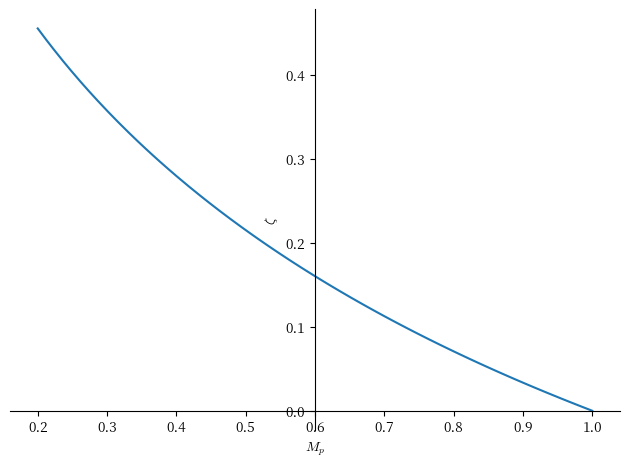

In [29]:
sp.plot(sol, (M_p, 0.2, 1), xlabel=M_p, ylabel=zeta)
plt.show()

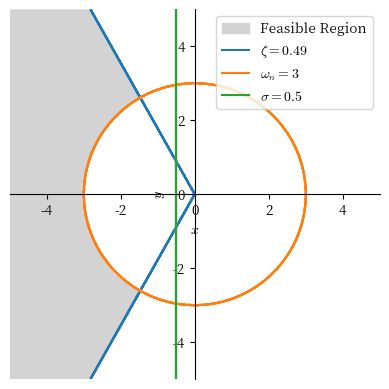

In [30]:
x, y = sp.symbols('x, y', real=True)

z = x + sp.I * y

omega_n = sp.Abs(z)
omega_d = y
sigma = -x
zeta = sigma / omega_n

p1 = sp.plot_implicit((zeta >= ans) & (omega_n >= 3) & (sigma >= 0.5),
                      line_color='lightgrey',
                      show=False)
p1.extend(
    sp.plot_implicit(sp.Eq(zeta, ans),
                     adaptive=False,
                     points=1000,
                     line_color='C0',
                     show=False))
p1.extend(
    sp.plot_implicit(sp.Eq(omega_n, 3),
                     adaptive=False,
                     points=1000,
                     line_color='C1',
                     show=False))
p1.extend(
    sp.plot_implicit(sp.Eq(sigma, 0.5),
                     adaptive=False,
                     points=1000,
                     line_color='C2',
                     show=False))


def move_sympyplot_to_axes(p, ax):
    backend = p.backend(p)
    backend.ax = ax
    backend._process_series(backend.parent._series, ax, backend.parent)
    backend.ax.spines['right'].set_color('none')
    backend.ax.spines['bottom'].set_position('zero')
    backend.ax.spines['top'].set_color('none')
    plt.close(backend.fig)


patches = [
    mpl.patches.Patch(color='lightgrey', label='Feasible Region'),
    mpl.lines.Line2D([0], [0], color='C0', label=f'$\\zeta = {ans:.2f}$'),
    mpl.lines.Line2D([0], [0], color='C1', label='$\\omega_n = 3$'),
    mpl.lines.Line2D([0], [0], color='C2', label='$\\sigma = 0.5$'),
]

fig, ax = plt.subplots()
move_sympyplot_to_axes(p1, ax)
ax.legend(handles=patches)
ax.set_aspect('equal')
fig.savefig('HW3_prob2.png', bbox_inches='tight')
plt.show()

# Problem 3

In [31]:
G = Rational('0.2') / (s + Rational('0.104'))
V_a = 10 / s
Omega = G * V_a

sp.Eq(Omega, sp.apart(Omega))

Eq(2/(s*(s + 13/125)), -31250/(13*(125*s + 13)) + 250/(13*s))

In [32]:
K = sp.symbols('K', positive=True)
sp.solve(0.052 / sp.sqrt(0.2 * K) > sol.evalf(subs={M_p: 0.2}))

K < 0.0650343212563473

In [33]:
sp.solve(0.052 / sp.sqrt(0.2 * K) < 1)

0.01352 < K

In [34]:
sp.solve((2.16 * 0.052 / sp.sqrt(0.2 * K) + 0.60) / sp.sqrt(0.2 * K) < 4)

0.334341911527148 < K

In [35]:
def compute_output(K, theta_r=sp.Heaviside(t)):
    G = Rational('0.2') * K / (s**2 + Rational('0.104') * s +
                               Rational('0.2') * K)
    Theta_r = sp.laplace_transform(theta_r, t, s, noconds=True)
    Theta_m = sp.apart(G * Theta_r)
    theta_m = sp.inverse_laplace_transform(Theta_m, s, t)
    return theta_m, Theta_m


theta_m1, Theta_m1 = compute_output(Rational(0.5))
theta_m2, Theta_m2 = compute_output(Rational(1))
theta_m3, Theta_m3 = compute_output(Rational(2))
display(Theta_m1, Theta_m2, Theta_m3)
display(theta_m1, theta_m2, theta_m3)

-2*(125*s + 13)/(250*s**2 + 26*s + 25) + 1/s

-(125*s + 13)/(125*s**2 + 13*s + 25) + 1/s

-(125*s + 13)/(125*s**2 + 13*s + 50) + 1/s

(6081*exp(13*t/250) - 13*sqrt(6081)*sin(sqrt(6081)*t/250) - 6081*cos(sqrt(6081)*t/250))*exp(-13*t/250)*Heaviside(t)/6081

(12331*exp(13*t/250) - 13*sqrt(12331)*sin(sqrt(12331)*t/250) - 12331*cos(sqrt(12331)*t/250))*exp(-13*t/250)*Heaviside(t)/12331

(8277*exp(13*t/250) - 13*sqrt(2759)*sin(3*sqrt(2759)*t/250) - 8277*cos(3*sqrt(2759)*t/250))*exp(-13*t/250)*Heaviside(t)/8277

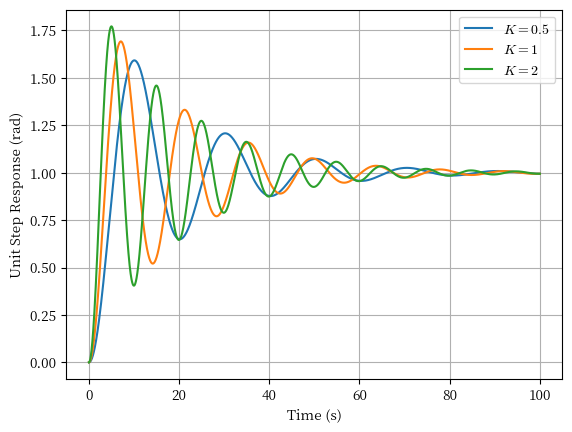

In [36]:
ls = np.linspace(0, 100, 100000)
sys1 = sp.lambdify(t, theta_m1)(ls)
sys2 = sp.lambdify(t, theta_m2)(ls)
sys3 = sp.lambdify(t, theta_m3)(ls)

fig, ax = plt.subplots()

ax.plot(ls, sys1, label=r'$K=0.5$')
ax.plot(ls, sys2, label=r'$K=1$')
ax.plot(ls, sys3, label=r'$K=2$')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Unit Step Response (rad)')
ax.legend()
ax.grid()
fig.savefig('HW3_prob3.png', bbox_inches='tight')

In [37]:
S = ct.step_info(sys1, ls, yfinal=1)
S = pd.DataFrame(S, index=['K=0.5']).T
S['K=1'] = ct.step_info(sys2, ls, yfinal=1).values()
S['K=2'] = ct.step_info(sys3, ls, yfinal=1).values()
S = S.round(3)
S.to_csv('HW3_prob3.csv')
S

,K=0.5,K=1,K=2
RiseTime,3.688,2.503,1.720
SettlingTime,72.715,72.240,75.113
SettlingMin,0.649,0.521,0.404
SettlingMax,1.592,1.692,1.772
Overshoot,59.231,69.227,77.169
Undershoot,0.000,0.000,0.000
Peak,1.592,1.692,1.772
PeakTime,10.072,7.073,4.984
SteadyStateValue,1.000,1.000,1.000


In [38]:
import gc
gc.collect()

26273

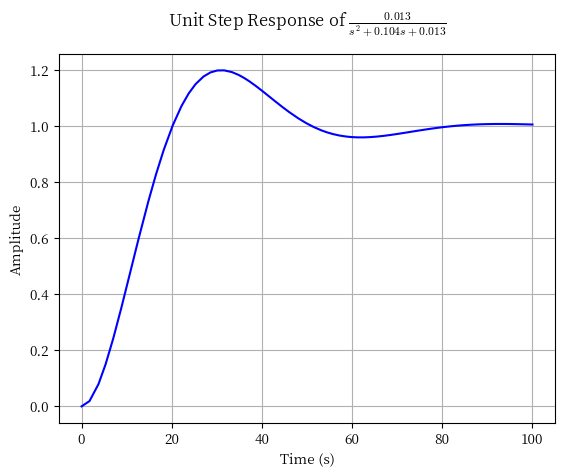

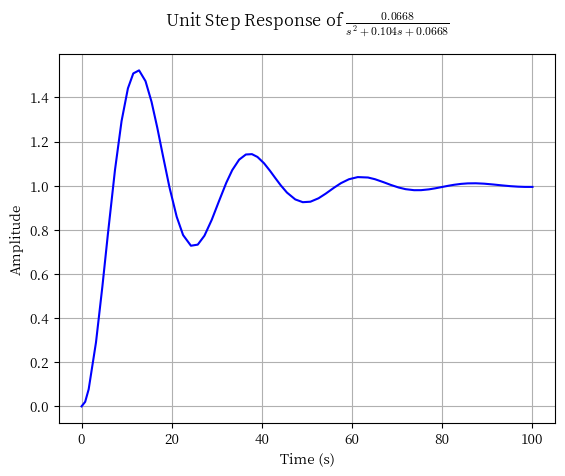

In [39]:
K = 0.065
tf = TransferFunction(0.2 * K, s**2 + 0.104 * s + 0.2 * K, s)
step_response_plot(tf, upper_limit=100)

K = 0.334
tf = TransferFunction(0.2 * K, s**2 + 0.104 * s + 0.2 * K, s)
step_response_plot(tf, upper_limit=100)


# Problem 4

In [40]:
K = sp.symbols('K')

A = sp.zeros(6)
A[0] = [1, 5]
A[1] = [10, 10]
A[2] = [5, K]

for i in range(2, 6):
    for j in range(0, 6 - i):
        A[i, j] = sp.simplify(A[i - 2, j + 1] -
                              A[i - 2, 0] * A[i - 1, j + 1] / A[i - 1, 0])

A

Matrix([
[                                  1,      10, 5, 0, 0, 0],
[                                  5,      10, K, 0, 0, 0],
[                                  8, 5 - K/5, 0, 0, 0, 0],
[                         K/8 + 55/8,       K, 0, 0, 0, 0],
[(-K**2 - 350*K + 1375)/(5*(K + 55)),       0, 0, 0, 0, 0],
[                                  K,       0, 0, 0, 0, 0]])

In [41]:
sp.simplify(
    sp.solve(A[3, 0] > 0, K) & sp.solve(A[4, 0] > 0, K)
    & sp.solve(A[5, 0] > 0, K))


(K > 0) & (K < oo) & ((K < -175 + 80*sqrt(5)) | (K < -80*sqrt(5) - 175))

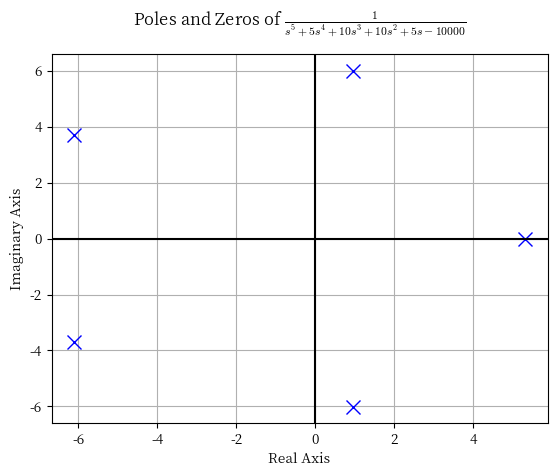

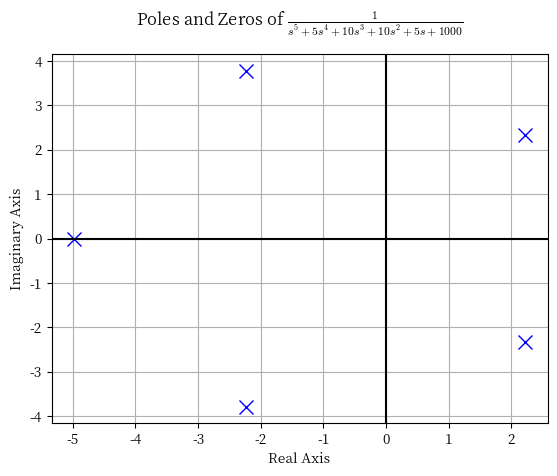

In [42]:
def K_plot(K):
    tf = TransferFunction(1,
                          s**5 + 5 * s**4 + 10 * s**3 + 10 * s**2 + 5 * s + K,
                          s)
    return pole_zero_plot(tf, show=False)


K_plot(-10000)
plt.savefig('HW3_prob4a.png', bbox_inches='tight')
plt.show()
K_plot(1000)
plt.savefig('HW3_prob4b.png', bbox_inches='tight')


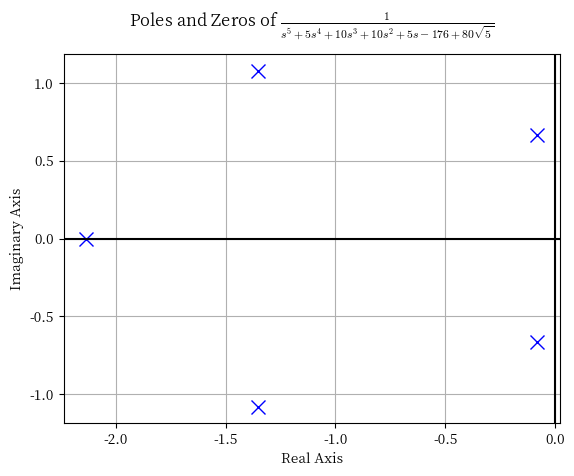

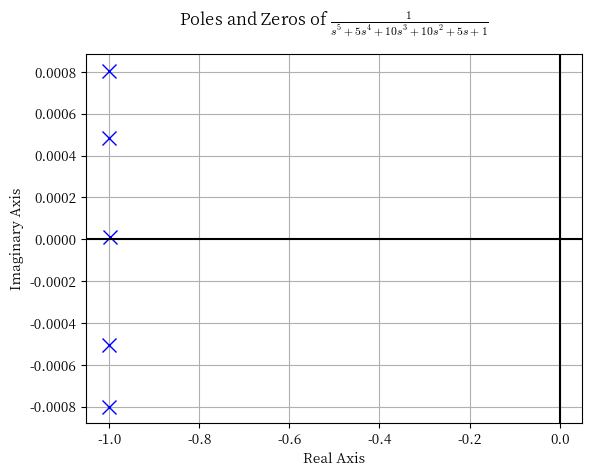

In [43]:
K_plot(80 * sp.sqrt(5) - 176)
plt.savefig('HW3_prob4c.png', bbox_inches='tight')
plt.show()
K_plot(1)
plt.savefig('HW3_prob4d.png', bbox_inches='tight')

# Problem 5

In [44]:
K, K_o, a, p, z = sp.symbols('K K_o a p z')

G = K * (s + z) / (s + p)
G_o = K_o / (s**2 - a**2)

G = sp.simplify(G * G_o / (1 + G * G_o))

sp.Matrix(sp.denom(G).as_poly(s).all_coeffs()).T

Matrix([[1, p, K*K_o - a**2, K*K_o*z - a**2*p]])

In [45]:
A = sp.zeros(4)
A[0] = [1, p]
A[1] = [K * K_o - a**2, K * K_o * z - a**2 * p]

for i in range(2, 4):
    for j in range(0, 4 - i):
        A[i, j] = sp.simplify(A[i - 2, j + 1] -
                              A[i - 2, 0] * A[i - 1, j + 1] / A[i - 1, 0])

# sp.print_latex(A)
A


Matrix([
[               1,     K*K_o - a**2, 0, 0],
[               p, K*K_o*z - a**2*p, 0, 0],
[ K*K_o*(p - z)/p,                0, 0, 0],
[K*K_o*z - a**2*p,                0, 0, 0]])

# Problem 9

In [46]:
ans = sol.evalf(subs={M_p: 0.1})
zeta > ans

-x/sqrt(x**2 + y**2) > 0.591155033798898

In [47]:
sp.N(100 * ans**2 / 0.01**2)


349464.273985776

In [48]:
K_1, K_2, K_3, = sp.symbols('K_1 K_2 K_3', real=True)

I = 25
G_o = TransferFunction(K_1 * K_2, s * (I * s + K_1 * K_2 * K_3), s)
G_c = TransferFunction(K_1 * K_2, I * s**2 + K_1 * K_2 * K_3 * s + K_1 * K_2,
                       s)
E_c = TransferFunction(I * s**2 + K_1 * K_2 * K_3 * s,
                       I * s**2 + K_1 * K_2 * K_3 * s + K_1 * K_2, s)
E_o = TransferFunction(s * (I * s + K_1 * K_2 * K_3) - K_1 * K_2,
                       s * (I * s + K_1 * K_2 * K_3), s)


In [49]:
def K123_plot(k_1, k_2, k_3, tf):
    x, y = ramp_response_numerical_data(tf.subs({
        K_1: k_1,
        K_2: k_2,
        K_3: k_3
    }),
                                        upper_limit=20)
    plt.plot(x, y)
    plt.ylim(0, 1.1)


interactive(K123_plot,
            k_1=(0, 20),
            k_2=(0, 20),
            k_3=FloatSlider(min=0, max=1, step=0.01, value=0),
            tf=[('闭环误差', E_c), ('开环误差', E_o), ('闭环输出', G_c), ('开环输出', G_o)])

interactive(children=(IntSlider(value=10, description='k_1', max=20), IntSlider(value=10, description='k_2', m…